In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit

In [2]:
kelly = ["#ebce2b", "#702c8c", "#db6917", "#96cde6", "#ba1c30", "#c0bd7f", "#7f7e80", "#5fa641", "#d485b2", "#4277b6", "#df8461", "#463397", "#e1a11a", "#91218c", "#e8e948", "#7e1510", "#92ae31", "#6f340d", "#d32b1e", "#2b3514",]

# Reading the csv file of benchmark run

In [3]:
df = pd.read_csv('../03-metrics.csv')

In [4]:
df.columns

Index(['Force Field', 'SMILES', 'Conformer Idx', 'RMSD', 'Bond RMSD',
       'Angle RMSD', 'Dihedral RMSD', 'Improper RMSD', 'TFD', 'FB OBJECTIVE',
       'Record ID', 'ddE'],
      dtype='object')

In [5]:
# a is a list
def function_hist(a, ini, final, nbins):
    bins = np.linspace(ini, final, nbins)
    counts, bins = np.histogram(np.array(a), bins)
    return counts, bins

In [6]:
ff_list = list(df['Force Field'].unique())

# RMSD/TFD/ddE distributions with rolling point average

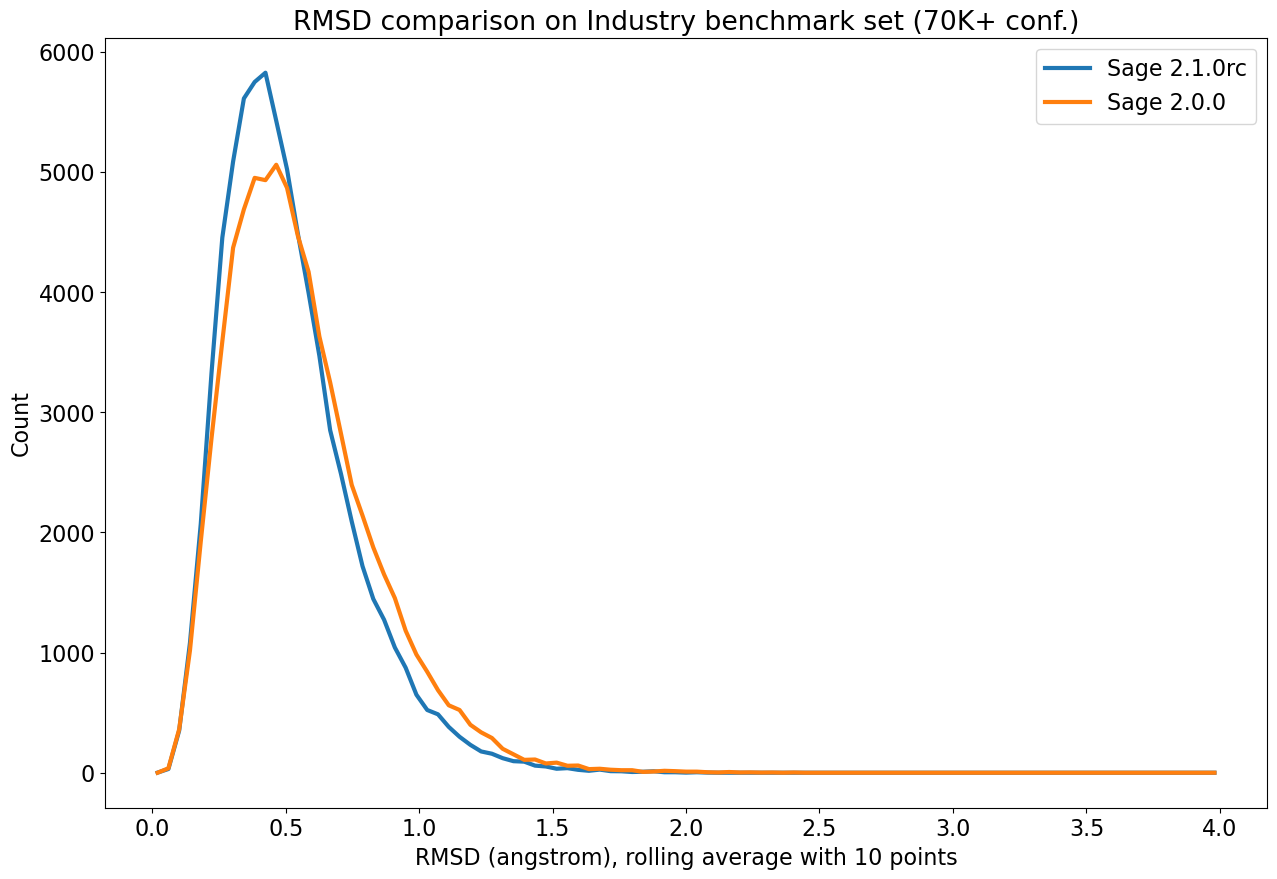

In [7]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

average_window = 10
for forcefield in ff_list:
    t_average = df.loc[df['Force Field'] == forcefield]["RMSD"].rolling(window=average_window).mean()
    n,x = function_hist(t_average, 0, 4, 100) #plt.hist(t_average, bins = np.linspace(0,3,200), histtype=u'step', color='w')
    bin_centers = 0.5*(x[1:]+x[:-1])
    if forcefield == 'GAFF 2.11 + AM1BCC':
        plt.plot(bin_centers, n, '-.', linewidth=3, label=forcefield) ## using bin_centers rather than edges
    else:
        plt.plot(bin_centers, n, linewidth=3, label=forcefield)
        
plt.xlabel(f"RMSD (angstrom), rolling average with {average_window} points")
plt.ylabel("Count")
plt.legend()
plt.title('RMSD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'Rolling_average_of_{average_window}_RMSD.png', dpi=300)
plt.show()

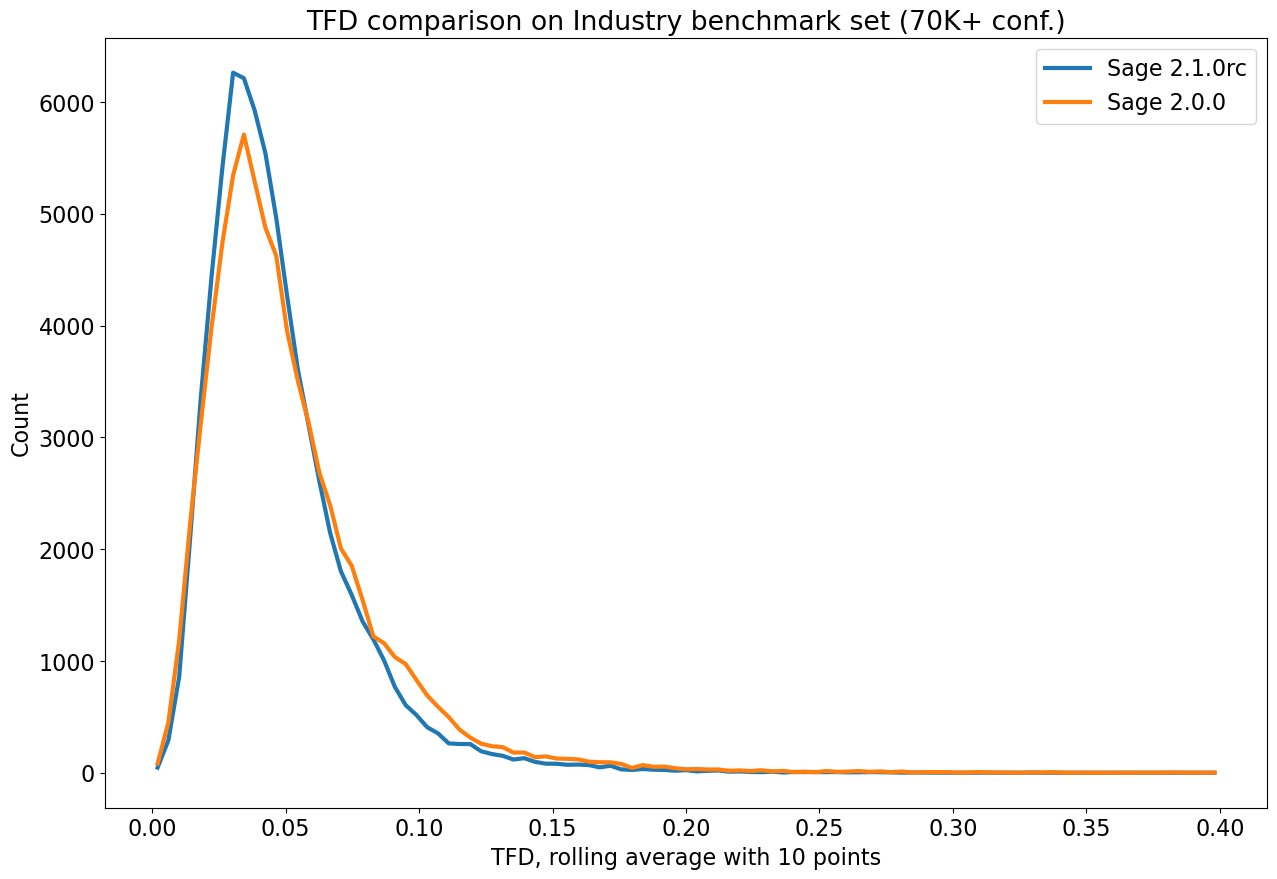

In [8]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

average_window = 10
for forcefield in ff_list:
    t_average = df.loc[df['Force Field'] == forcefield]["TFD"].rolling(window=average_window).mean()
    n,x = function_hist(t_average, 0, 0.4, 100) #plt.hist(t_average, bins = np.linspace(0,3,200), histtype=u'step', color='w')
    bin_centers = 0.5*(x[1:]+x[:-1])
    if forcefield == 'GAFF 2.11 + AM1BCC':
        plt.plot(bin_centers, n, '-.', linewidth=3, label=forcefield) ## using bin_centers rather than edges
    else:
        plt.plot(bin_centers, n, linewidth=3, label=forcefield)
        
plt.xlabel(f"TFD, rolling average with {average_window} points")
plt.ylabel("Count")
plt.legend()
plt.title('TFD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'Rolling_average_of_{average_window}_TFD.png', dpi=300)
plt.show()

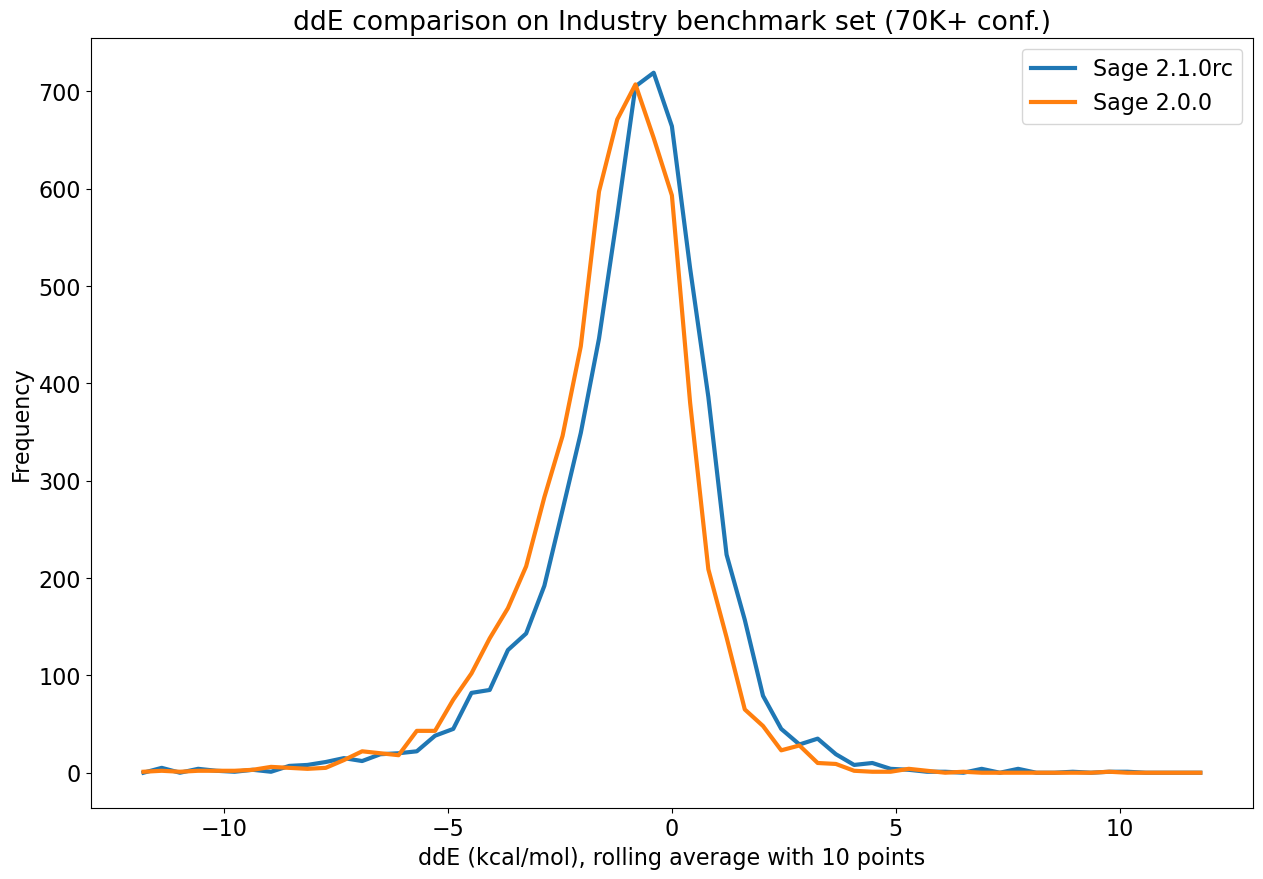

In [9]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

average_window = 10
for forcefield in ff_list:
    t_average = df.loc[df['Force Field'] == forcefield]["ddE"].rolling(window=average_window).mean()
    n,x = function_hist(t_average, -12, 12, 60) #plt.hist(t_average, bins = np.linspace(0,3,200), histtype=u'step', color='w')
    bin_centers = 0.5*(x[1:]+x[:-1])
    if forcefield == 'GAFF 2.11 + AM1BCC':
        plt.plot(bin_centers, n, '-.', linewidth=3, label=forcefield) ## using bin_centers rather than edges
    else:
        plt.plot(bin_centers, n, linewidth=3, label=forcefield)
        
plt.xlabel(f"ddE (kcal/mol), rolling average with {average_window} points")
plt.ylabel("Frequency")
plt.legend()
plt.title('ddE comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'Rolling_average_of_{average_window}_ddE.png', dpi=300)
plt.show()

# RMSD/TFD/|ddE| distributions with log transform of the data and fit to gaussians

Sage 2.1.0rc [ 1.47829971e+03 -9.91772686e-01  7.41960978e-01]
Sage 2.0.0 [ 1.56054211e+03 -9.03315413e-01  8.03014815e-01]


<Figure size 1500x1000 with 0 Axes>

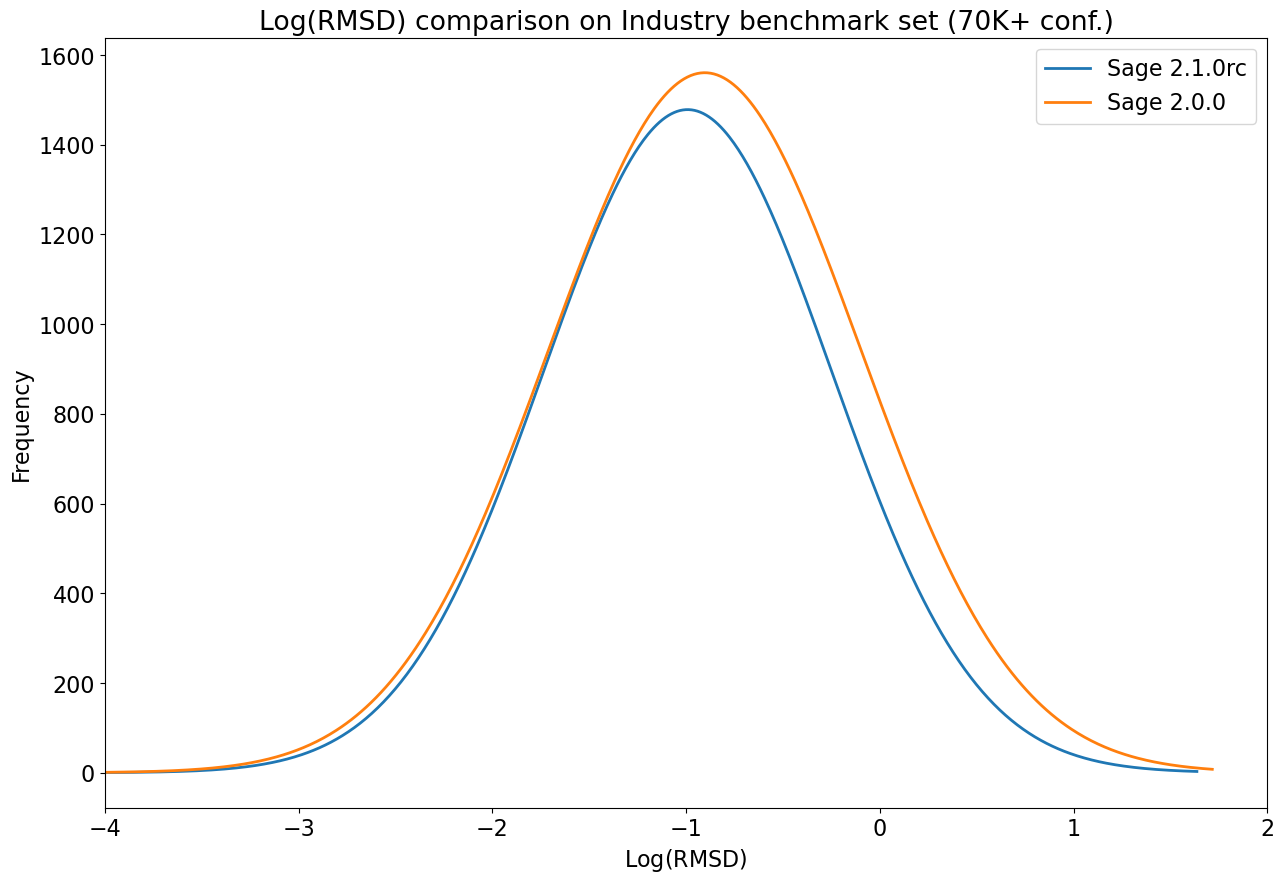

In [10]:


#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(15,10))#1,2, figsize=(10,5), gridspec_kw={'wspace':0.2})


labels = ff_list
for ii, forcefield in enumerate(labels):
    data = df.loc[df['Force Field'] == forcefield]["RMSD"]
    data = np.log(data[data != 0])
    
    no_bins = 200
    hist,left = np.histogram(data,bins=no_bins)
    centers = left[:-1] + (left[1] - left[0])
    
    mean = np.mean(data)
    sigma = np.std(data)
    p0 = [1, mean, sigma] #starting values for the fit
    #fit the histogram
    p1,_ = curve_fit(gauss_function,centers,hist,p0,maxfev=100000)

#     ax.hist(data,bins=no_bins)
    x = np.linspace(left[0],left[-1],1000)
    y_fit = gauss_function(x, *p1)
    if forcefield == 'GAFF 2.11 + AM1BCC':
        ax.plot(x,y_fit,'-.', linewidth=2, label=labels[ii])
    else:
        ax.plot(x,y_fit,'-', linewidth=2, label=labels[ii])
    print(labels[ii], p1)

plt.xlim((-4, 2))    
plt.xlabel(r"$\mathregular{Log(RMSD)}$")
plt.ylabel("Frequency")
plt.legend()
plt.title('Log(RMSD) comparison on Industry benchmark set (70K+ conf.)')
plt.savefig('Log_transform_of_rmsd.png', dpi=300)
plt.show()



Sage 2.1.0rc [ 4.40599222e+03 -3.26800609e+00  7.28362405e-01]
Sage 2.0.0 [ 4.04909325e+03 -3.23292915e+00  8.03259384e-01]


<Figure size 1500x1000 with 0 Axes>

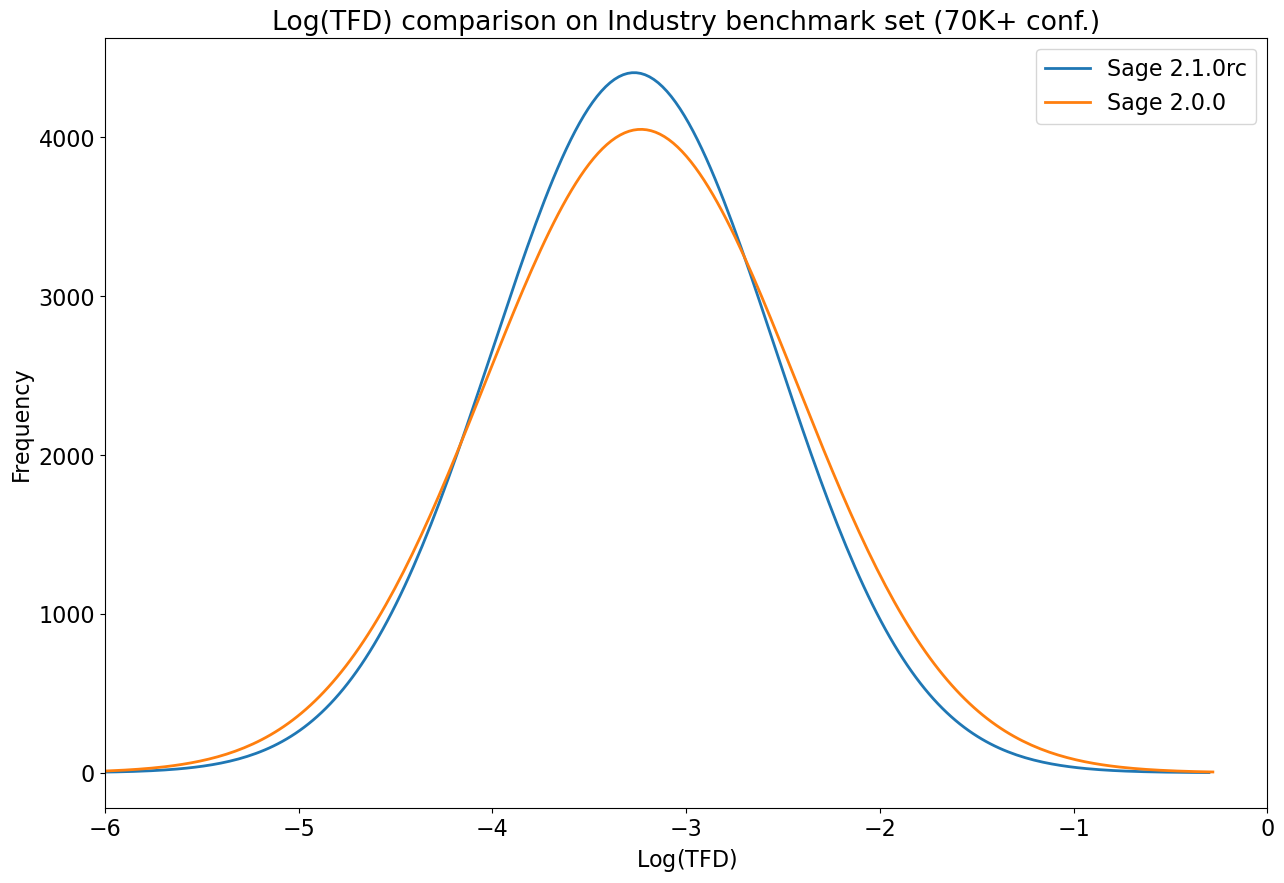

In [11]:
#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(15,10))#1,2, figsize=(10,5), gridspec_kw={'wspace':0.2})


labels = ff_list
for ii, forcefield in enumerate(labels):
    data = df.loc[df['Force Field'] == forcefield]["TFD"]
    data = data[~np.isnan(data)]
    data = np.log(data[data != 0])
    
    no_bins = 200
    hist,left = np.histogram(data,bins=no_bins)
    centers = left[:-1] + (left[1] - left[0])
    
    mean = np.mean(data)
    sigma = np.std(data)
    p0 = [1, mean, sigma] #starting values for the fit
    #fit the histogram
    p1,_ = curve_fit(gauss_function,centers,hist,p0,maxfev=100000)

#     ax.hist(data,bins=no_bins)
    x = np.linspace(left[0],left[-1],1000)
    y_fit = gauss_function(x, *p1)
    if forcefield == 'GAFF 2.11 + AM1BCC':
        ax.plot(x,y_fit,'-.', linewidth=2, label=labels[ii])
    else:
        ax.plot(x,y_fit,'-', linewidth=2, label=labels[ii])
    print(labels[ii], p1)

plt.xlim((-6, 0))    
plt.xlabel(r"$\mathregular{Log(TFD)}$")
plt.ylabel("Frequency")
plt.legend()
plt.title('Log(TFD) comparison on Industry benchmark set (70K+ conf.)')
plt.savefig('Log_transform_of_tfd.png', dpi=300)
plt.show()

Sage 2.1.0rc [ 2.44750979e+03  5.50665045e-01 -1.07277654e+00]
Sage 2.0.0 [2.44677022e+03 5.91264567e-01 1.07608957e+00]


<Figure size 1500x1000 with 0 Axes>

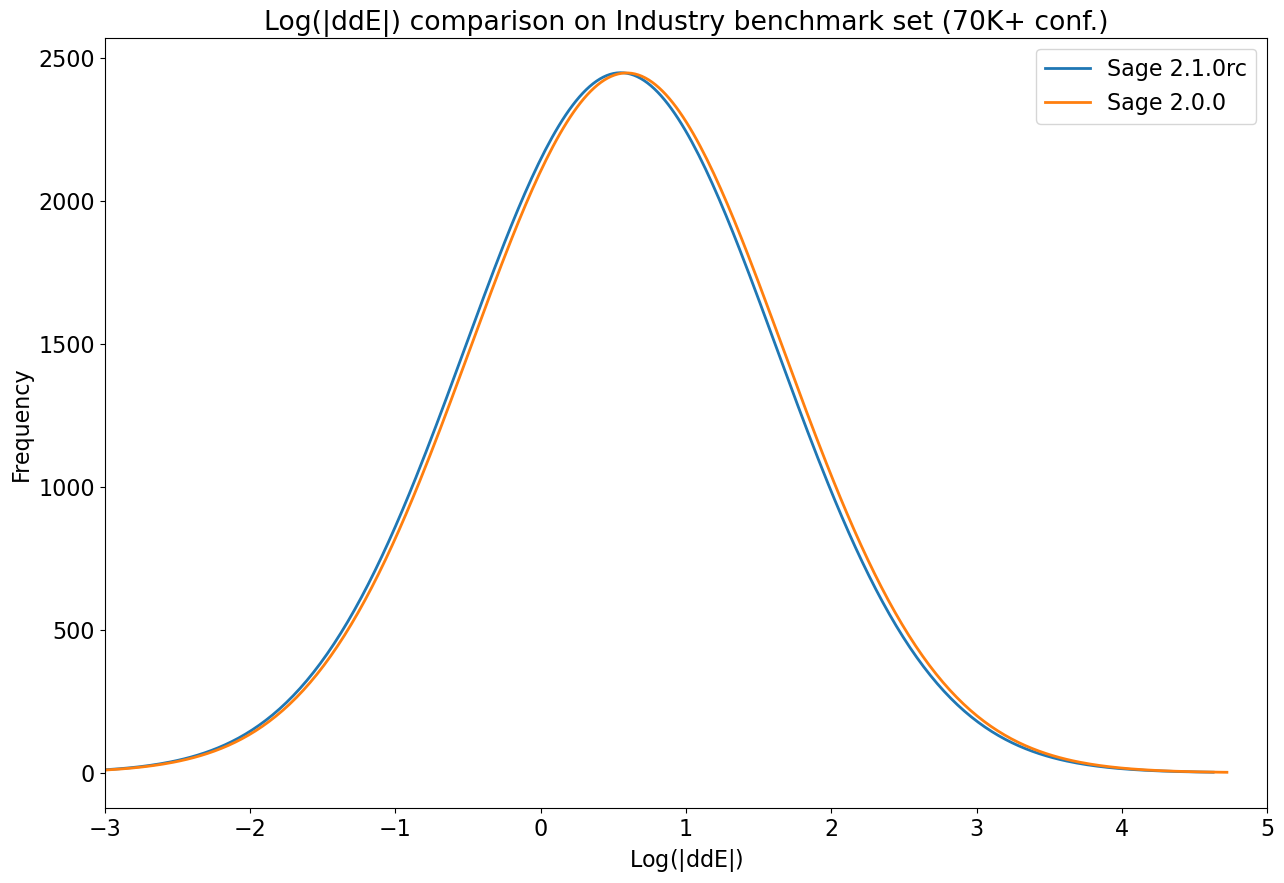

In [12]:
#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(15,10))#1,2, figsize=(10,5), gridspec_kw={'wspace':0.2})


labels = ff_list
for ii, forcefield in enumerate(labels):
    data = df.loc[df['Force Field'] == forcefield]["ddE"]
    data = data[~np.isnan(data)]
    data = np.log(np.abs(data[data != 0]))
    
    no_bins = 200
    hist,left = np.histogram(data,bins=no_bins)
    centers = left[:-1] + (left[1] - left[0])
    
    mean = np.mean(data)
    sigma = np.std(data)
    p0 = [1, mean, sigma] #starting values for the fit
    #fit the histogram
    p1,_ = curve_fit(gauss_function,centers,hist,p0,maxfev=100000)

#     ax.hist(data,bins=no_bins)
    x = np.linspace(left[0],left[-1],1000)
    y_fit = gauss_function(x, *p1)
    ax.plot(x,y_fit,'-', linewidth=2, label=labels[ii])
    print(labels[ii], p1)

plt.xlim((-3, 5))    
plt.xlabel(r"$\mathregular{Log(|ddE|)}$")
plt.ylabel("Frequency")
plt.legend()
plt.title('Log(|ddE|) comparison on Industry benchmark set (70K+ conf.)')
plt.savefig('Log_transform_of_absolute_ddE.png', dpi=300)
plt.show()

# KDE plots of the metrics RMSD/TFD/ddE

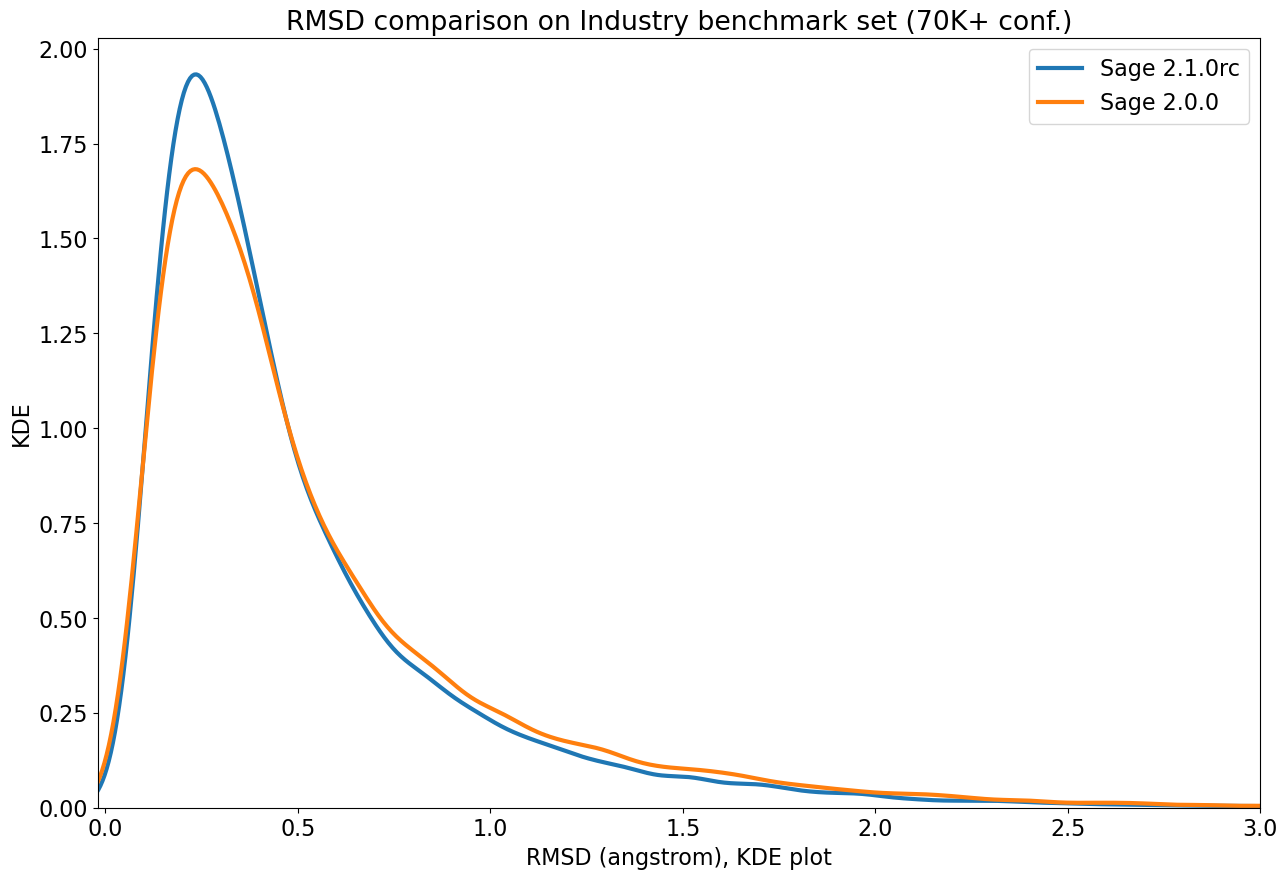

In [13]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["RMSD"], linestyle='-.', linewidth=3, label=forcefield, gridsize=1000, bw_adjust=1.0) ## using bin_centers rather than edges
    else:
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["RMSD"], linewidth=3, label=forcefield, gridsize=1000, bw_adjust=1.0)

plt.xlim(-0.02, 3)
plt.xlabel(f"RMSD (angstrom), KDE plot")
plt.ylabel("KDE")
plt.legend()
plt.title('RMSD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'KDE_plot_of_RMSD.png', dpi=300)
plt.show()

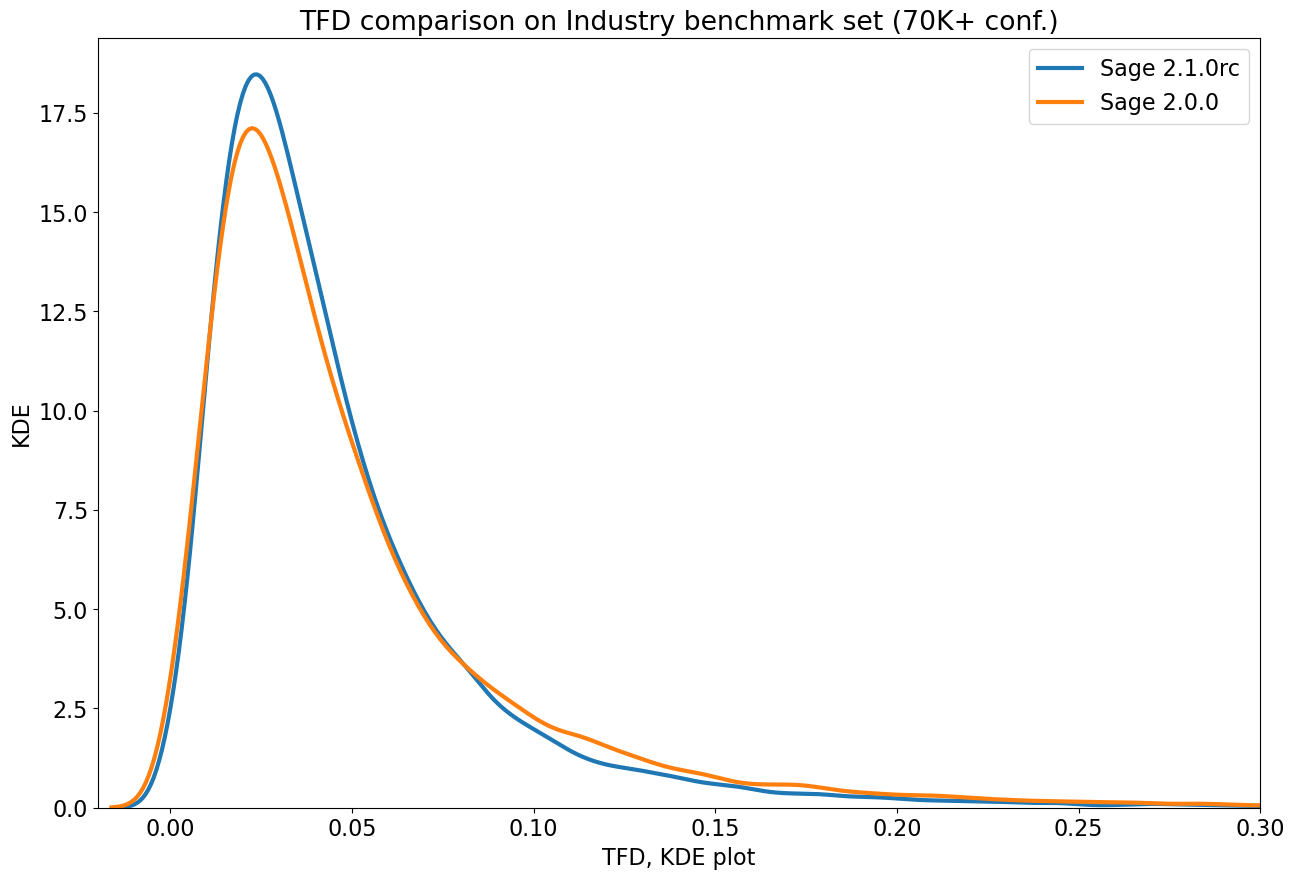

In [14]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["TFD"], linestyle='-.', linewidth=3, label=forcefield, gridsize=1000) ## using bin_centers rather than edges
    else:
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["TFD"], linewidth=3, label=forcefield, gridsize=1000)

plt.xlim(-0.02, 0.3)
plt.xlabel(f"TFD, KDE plot")
plt.ylabel("KDE")
plt.legend()
plt.title('TFD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'KDE_plot_of_TFD.png', dpi=300)
plt.show()

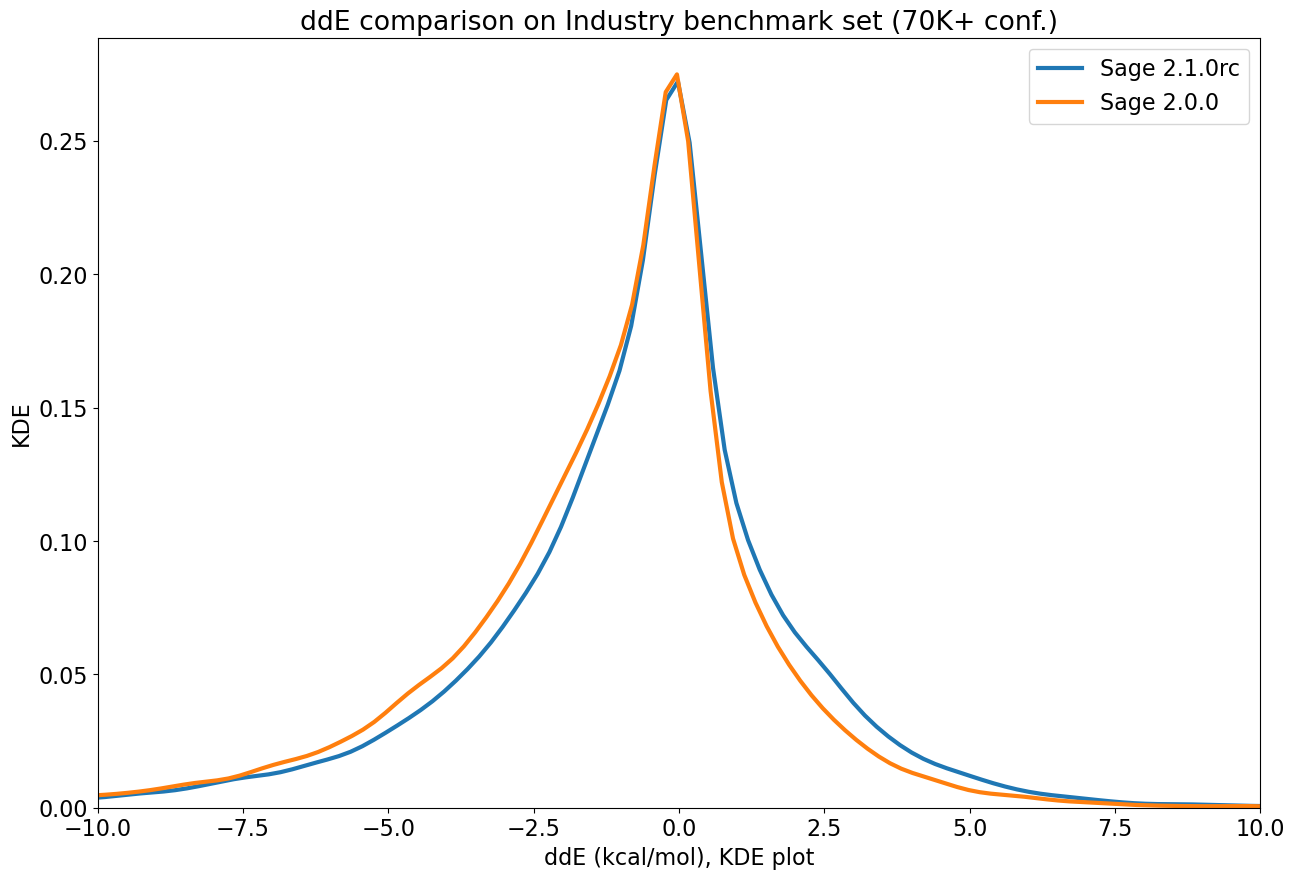

In [15]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["ddE"], linestyle='-.', linewidth=3, label=forcefield, gridsize=1000) ## using bin_centers rather than edges
    else:
        sns.kdeplot(df.loc[df['Force Field'] == forcefield]["ddE"], linewidth=3, label=forcefield, gridsize=1000)

plt.xlim(-10, 10)
plt.xlabel(f"ddE (kcal/mol), KDE plot")
plt.ylabel("KDE")
plt.legend()
plt.title('ddE comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'KDE_plot_of_ddE.png', dpi=300)
plt.show()

# Cumulative distributions of the metrics RMSD/TFD/ddE

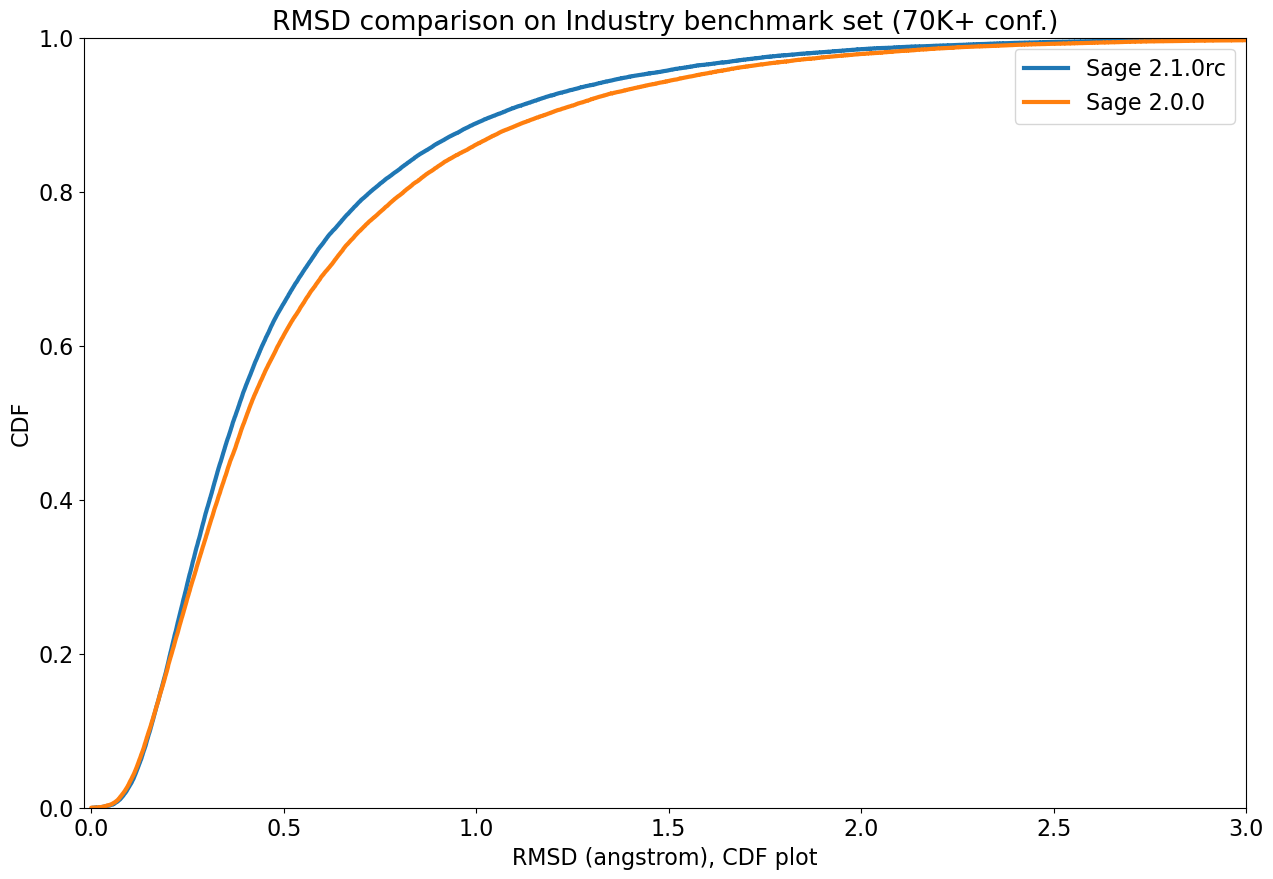

In [16]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.ecdfplot(df.loc[df['Force Field'] == forcefield]["RMSD"], linestyle='-.', linewidth=3, label=forcefield) 
    else:
        sns.ecdfplot(df.loc[df['Force Field'] == forcefield]["RMSD"], linewidth=3, label=forcefield)

plt.xlim(-0.02, 3)
plt.xlabel(f"RMSD (angstrom), CDF plot")
plt.ylabel("CDF")
plt.legend()
plt.title('RMSD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'CDF_plot_of_RMSD.png', dpi=300)
plt.show()

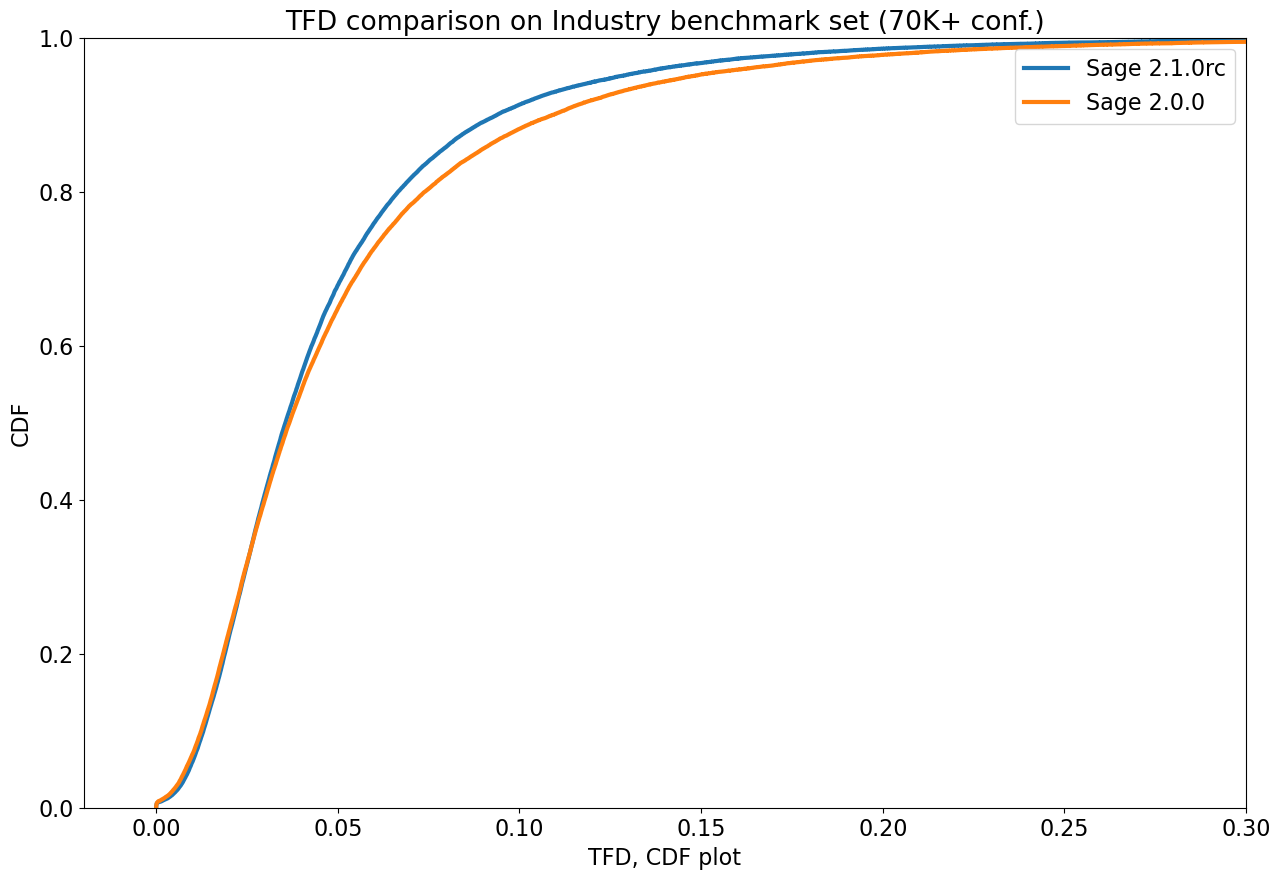

In [17]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.ecdfplot(df.loc[df['Force Field'] == forcefield]["TFD"], linestyle='-.', linewidth=3, label=forcefield)
    else:
        sns.ecdfplot(df.loc[df['Force Field'] == forcefield]["TFD"], linewidth=3, label=forcefield)

plt.xlim(-0.02, 0.3)
plt.xlabel(f"TFD, CDF plot")
plt.ylabel("CDF")
plt.legend()
plt.title('TFD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'CDF_plot_of_TFD.png', dpi=300)
plt.show()

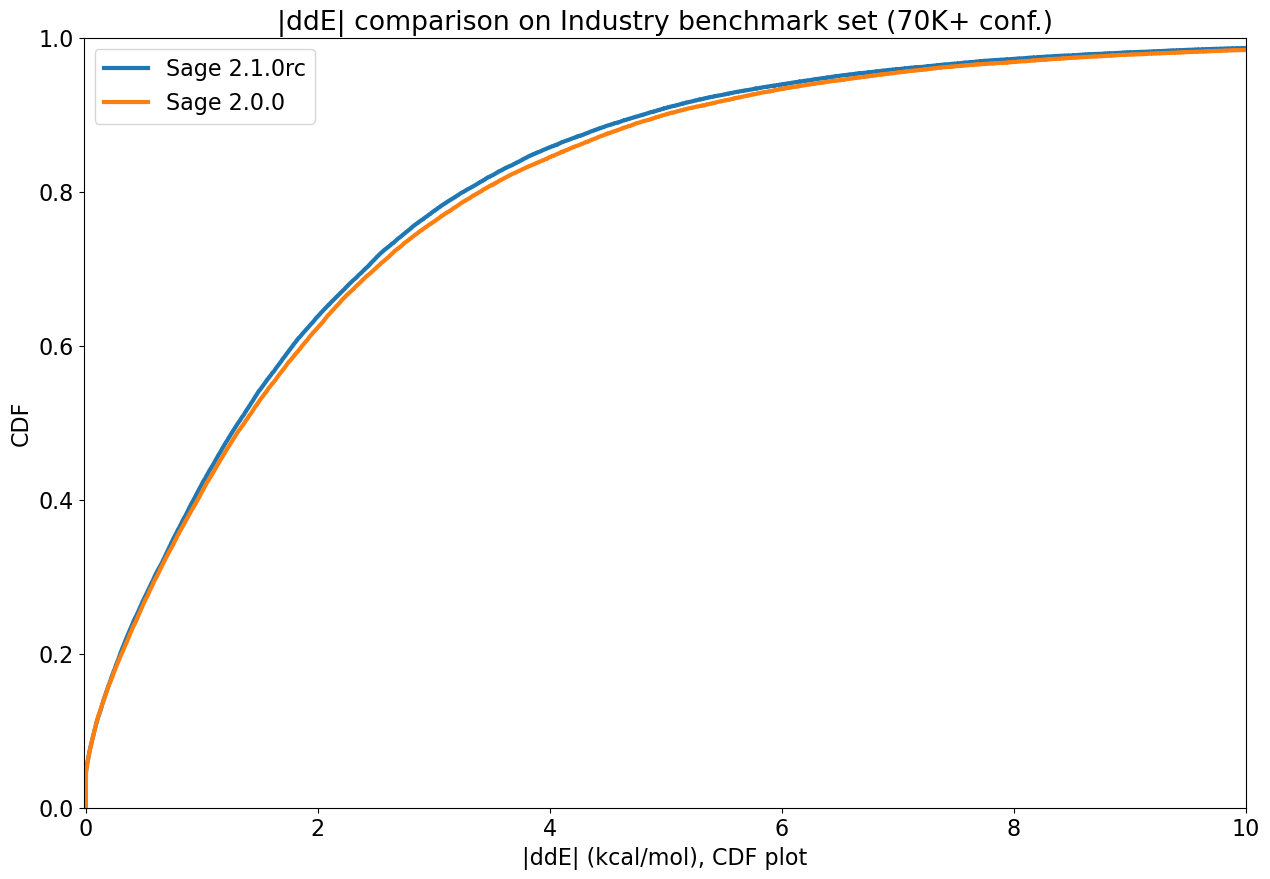

In [18]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.ecdfplot(abs(df.loc[df['Force Field'] == forcefield]["ddE"]), linestyle='-.', linewidth=3, label=forcefield)
    else:
        sns.ecdfplot(abs(df.loc[df['Force Field'] == forcefield]["ddE"]), linewidth=3, label=forcefield)

plt.xlim(-0.02, 10)
plt.xlabel(f"|ddE| (kcal/mol), CDF plot")
plt.ylabel("CDF")
plt.legend()
plt.title('|ddE| comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'CDF_plot_of_ddE.png', dpi=300)
plt.show()

# Log-normal distribution of data (instead of log transform and fitting to a gaussian)

/tmp/ipykernel_3872394/3963551011.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['Force Field'] == forcefield]["RMSD"], label=forcefield, kde=False, hist=True, norm_hist=True, fit =lognorm, bins=np.linspace(0,10,2000))


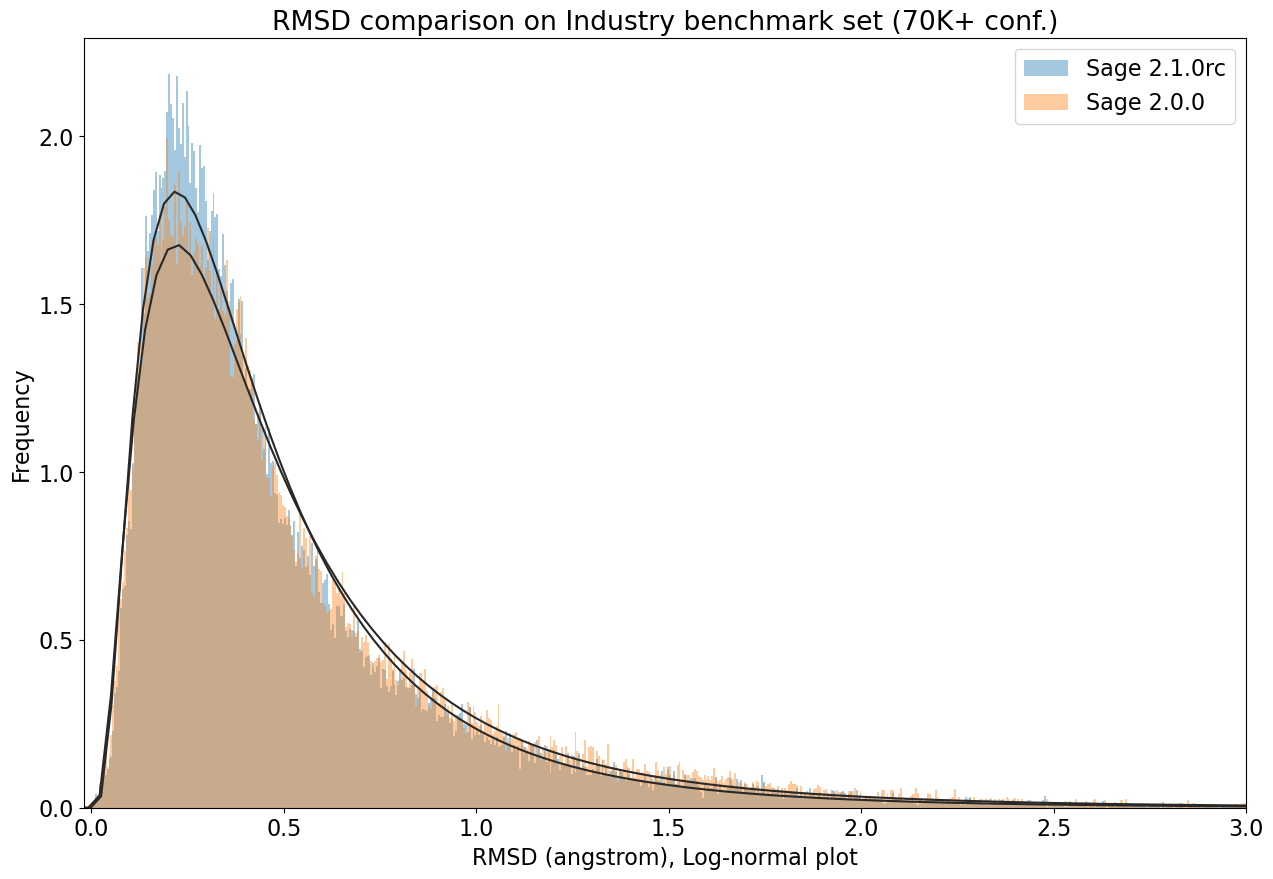

In [19]:

plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})


for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        sns.distplot(df.loc[df['Force Field'] == forcefield]["RMSD"], label=forcefield, kde=False, hist=True, norm_hist=True, fit =lognorm, bins=np.linspace(0,10,2000), kde_kws={"linestyle": '-.', 'linewidth': 3}) 
    else:
        sns.distplot(df.loc[df['Force Field'] == forcefield]["RMSD"], label=forcefield, kde=False, hist=True, norm_hist=True, fit =lognorm, bins=np.linspace(0,10,2000)) 

plt.xlim(-0.02, 3)
plt.xlabel(f"RMSD (angstrom), Log-normal plot")
plt.ylabel("Frequency")
plt.legend()
plt.title('RMSD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'lognormal_plot_of_RMSD.png', dpi=300)
plt.show()

Sage 2.1.0rc, mean: -0.9591, sigma: 0.7490
Sage 2.0.0, mean: -0.8974, sigma: 0.7904


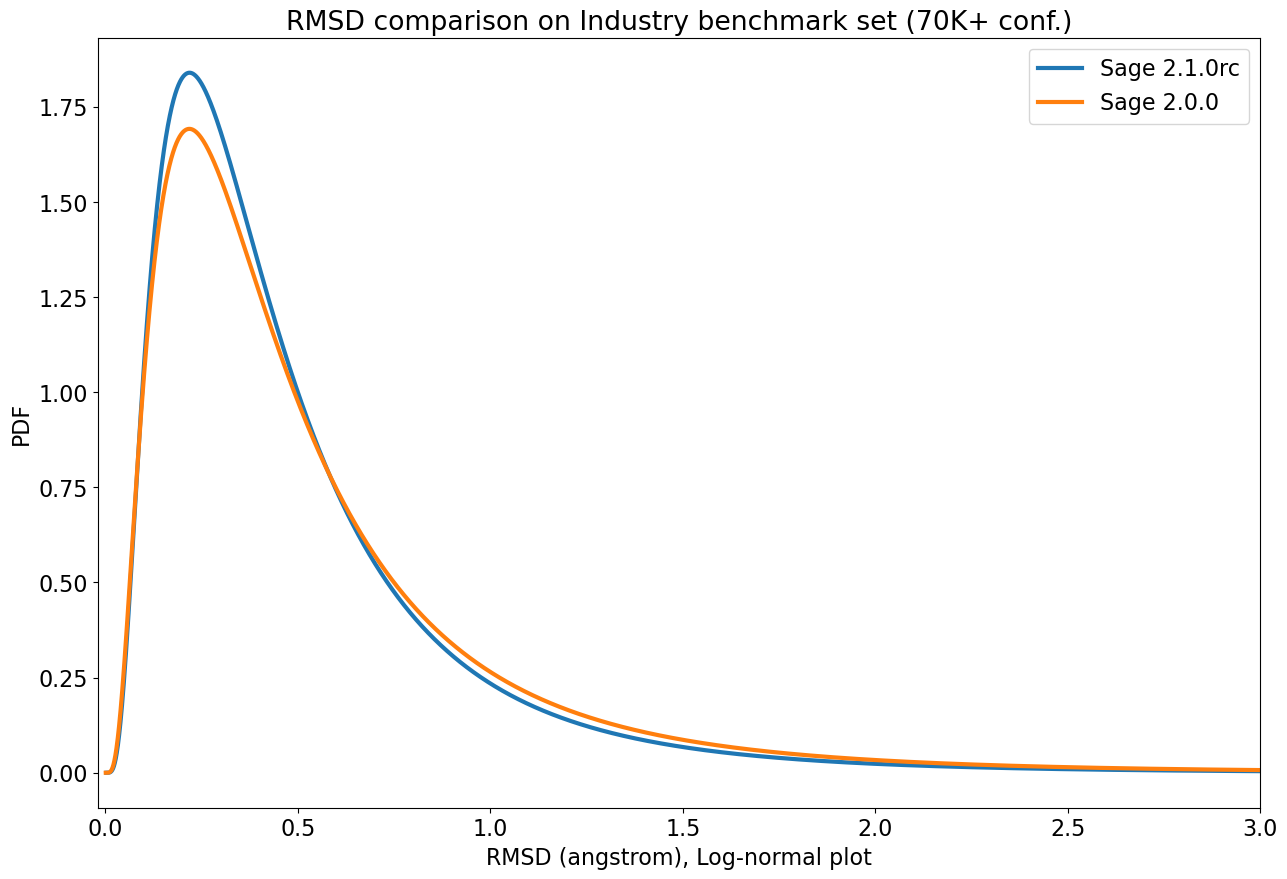

In [20]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        data = df.loc[df['Force Field'] == forcefield]["RMSD"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
#         plt.hist(data, bins=500, linestyle='-.', linewidth=3, label=forcefield, alpha=0.75)
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 10000)
        pdf = lognorm.pdf(x, s,  loc=loc, scale=scale)
        plt.plot(x, pdf, linestyle='-.', linewidth=3, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")
        
    else:
        data = df.loc[df['Force Field'] == forcefield]["RMSD"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
#         plt.hist(data, bins=500, alpha=0.75)
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 10000)
        pdf = lognorm.pdf(x, s, loc=loc, scale=scale)
        plt.plot(x, pdf, linewidth=3, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")
        

plt.xlim(-0.02, 3)
plt.xlabel(f"RMSD (angstrom), Log-normal plot")
plt.ylabel("PDF")
plt.legend()
plt.title('RMSD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'lognormal_plot_of_RMSD.png', dpi=300)
plt.show()

Sage 2.1.0rc, mean: -3.3883, sigma: 1.0196
Sage 2.0.0, mean: -3.3576, sigma: 1.0821


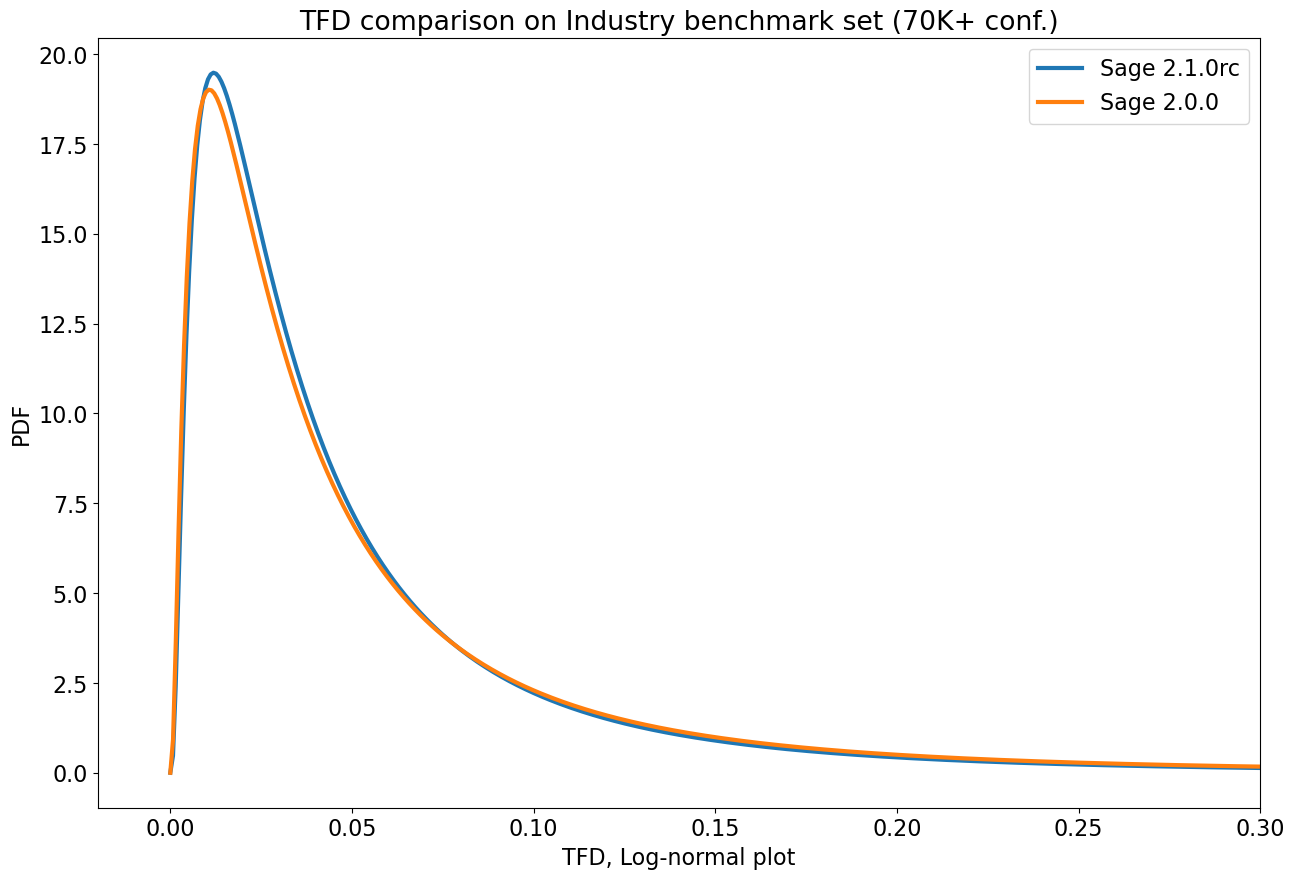

In [21]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        data = df.loc[df['Force Field'] == forcefield]["TDF"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
#         plt.hist(data, bins=500, linestyle='-.', linewidth=3, label=forcefield, alpha=0.75)
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 1000)
        pdf = lognorm.pdf(x, s,  loc=loc, scale=scale)
        plt.plot(x, pdf, linestyle='-.', linewidth=3, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")
        
    else:
        data = df.loc[df['Force Field'] == forcefield]["TFD"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
#         plt.hist(data, bins=500, alpha=0.75)
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 1000)
        pdf = lognorm.pdf(x, s, loc=loc, scale=scale)
        plt.plot(x, pdf, linewidth=3, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")
        

plt.xlim(-0.02, 0.3)
plt.xlabel(f"TFD, Log-normal plot")
plt.ylabel("PDF")
plt.legend()
plt.title('TFD comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'lognormal_plot_of_TFD.png', dpi=300)
plt.show()

Sage 2.1.0rc, mean: -0.3652, sigma: 2.4527
Sage 2.0.0, mean: -0.3281, sigma: 2.4509


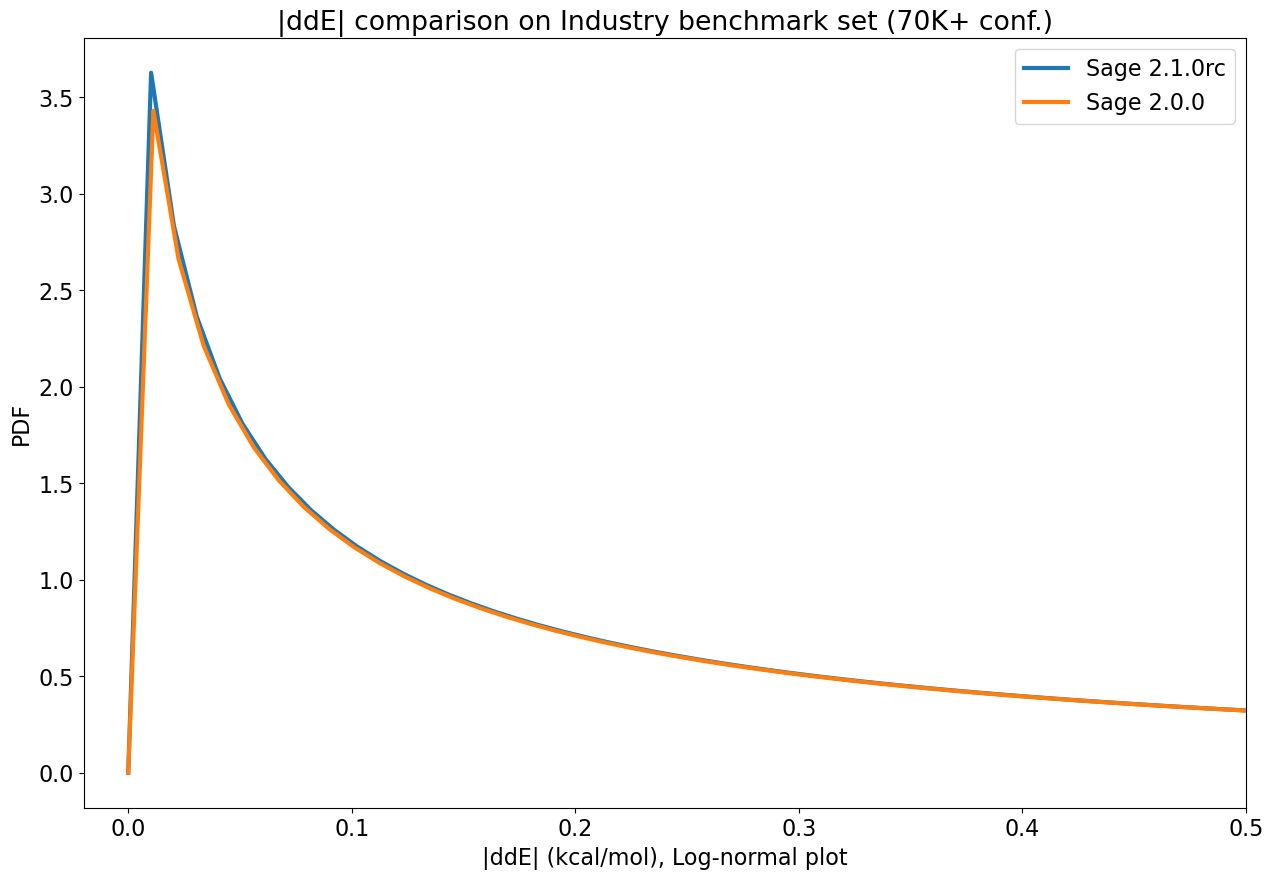

In [22]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

for forcefield in ff_list:
    if forcefield == 'GAFF 2.11 + AM1BCC':
        data = df.loc[df['Force Field'] == forcefield]["ddE"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        data = np.abs(data)
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 10000)
        pdf = lognorm.pdf(x, s,  loc=loc, scale=scale)
        plt.plot(x, pdf, linestyle='-.', linewidth=3, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")
        
    else:
        data = df.loc[df['Force Field'] == forcefield]["ddE"]
        data = data[~np.isnan(data)]
        data = data[data != 0]
        data = np.abs(data)
        s, loc, scale = lognorm.fit(data, floc=0)
        estimated_mu = np.log(scale)
        estimated_sigma = s
        xmin = data.min()
        xmax = data.max()
        x = np.linspace(xmin, xmax, 10000)
        pdf = lognorm.pdf(x, s, loc=loc, scale=scale)
        plt.plot(x, pdf, linewidth=3, label=forcefield)
        print(f"{forcefield}, mean: {estimated_mu:.4f}, sigma: {estimated_sigma:.4f}")


plt.xlim(-0.02, 0.5)
plt.xlabel(f"|ddE| (kcal/mol), Log-normal plot")
plt.ylabel("PDF")
plt.legend()
plt.title('|ddE| comparison on Industry benchmark set (70K+ conf.)')
plt.savefig(f'lognormal_plot_of_ddE.png', dpi=300)
plt.show()